# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%run nnn/ipynb_init.py
%matplotlib inline
import nupack
from nnn import train_nn as tnn
from itertools import product

# The handcrafted MUPACK

Regress out NNN pairs on newly reprocessed data, where refseq duplicates were filtered out from the reference file before the preprocessing steps. Contains the WC ones that are also tetraloop NNN.

In [47]:
# config = dict(
#     use_model_from='json',
#     test_mode='test',
#     secondary_struct = 'target'
# )
# mydata = tnn.MyData(config)
# mydata.load_everything()

(16, 13)
(5096, 12)


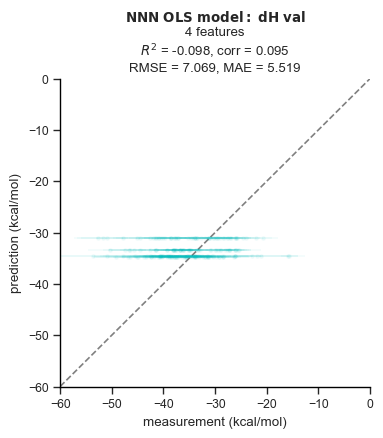

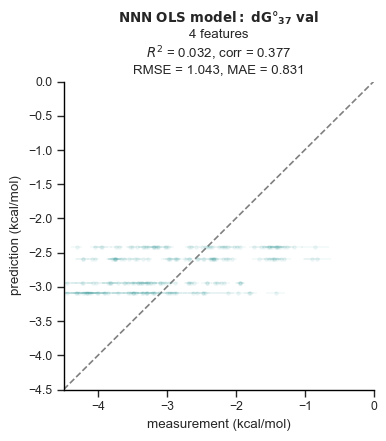

In [2]:
# All tetra and triloops, regressing NNN out.
config = dict(
    use_model_from='json',
    test_mode='test',
    secondary_struct = 'target'
)
mydata = tnn.MyData(config)
mydata.load_everything()
tloop_df = mf.regress_out_nnn_pair_tloop(mydata)

# Format tloop_df
hairpin_tloop_df = pd.DataFrame(
    dict(dH=tloop_df.groupby('tloop')['dH'].apply(np.mean),
         dG=tloop_df.groupby('tloop')['dG_37'].apply(np.mean))
)

triloop_ind = [x for x in hairpin_tloop_df.index if len(x) == 5]
tetraloop_ind = [x for x in hairpin_tloop_df.index if len(x) == 6]
hairpin_triloop_df = hairpin_tloop_df.loc[triloop_ind]
hairpin_tetraloop_df = hairpin_tloop_df.loc[tetraloop_ind]

## hairpin_triloop & hairpin_tetraloop parameters

Fill in `hairpin_triloop`, `hairpin_tetraloop`, and `hairpin_mismatch` parameters to the file `./models/dna-nnn-hploop.json`.

### json file names

In [21]:
param_set_template_file = './models/dna04.json'
param_set_hp_file = './models/dna-nnn-tloop.json'
param_set_hp_tmp_file = './models/dna-nnn-tloop-tmp.json'
param_set_hp_adj_file = './models/dna-nnn-tloop-adj.json'

### Write tloop_df values to json

In [10]:
p_ori_dict = fileio.read_json(param_set_template_file)
p_hp_dict = p_ori_dict.copy()

for p in ['dH', 'dG']:
    p_hp_dict[p]['hairpin_tetraloop'] = dict(hairpin_tetraloop_df[p])
    p_hp_dict[p]['hairpin_triloop'] = dict(hairpin_triloop_df[p])

fileio.write_json(p_hp_dict, param_set_hp_file)

### Evaluate tloop param file on training set

In [6]:
# A new version of arr_v0_1M
arr_1M = pd.read_csv('./data/models/processed/arr_v0_1M_n=30872.csv', index_col=0)

In [11]:
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]

In [83]:
%%time
val_result_df = modeling.make_model_validation_df(
    val_df,#.sample(100),
    model='nupack', 
    model_param_file=param_set_hp_file,
)

CPU times: user 24.8 s, sys: 259 ms, total: 25.1 s
Wall time: 25.2 s


In [83]:
# Save the full result (long run time)
val_result_df.to_csv('./data/models/out/train_result_dna-nnn-tloop.csv')

In [12]:
# Load the full result (long run time)
val_result_df = pd.read_csv('./data/models/out/train_result_dna-nnn-tloop.csv', index_col=0)

In [14]:
# Print the median of dH & dG offset
val_result_dict = dict()
val_result_dict['triloop'] = val_result_df.loc[[x.startswith('TRI') for x in val_result_df.index]]
val_result_dict['tetraloop'] = val_result_df.loc[[(not x.startswith('TRI')) and (not x.startswith('VAR')) for x in val_result_df.index]]

offset = dict(triloop=dict(), tetraloop=dict())

for key, df in val_result_dict.items():
    offset[key]['dH'] = np.median(val_result_dict[key].dH_pred - val_result_dict[key].dH)
    offset[key]['dG'] = np.median(val_result_dict[key].dG_37_pred - val_result_dict[key].dG_37)

print(offset)

{'triloop': {'dH': -39.386685806628634, 'dG': -0.814162875072435}, 'tetraloop': {'dH': -58.82417187815282, 'dG': -2.593613834551717}}


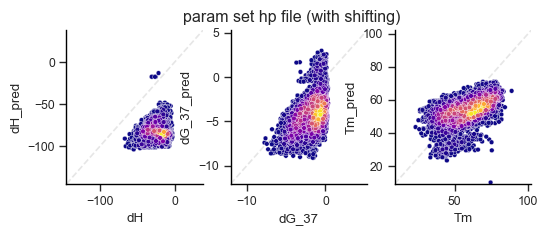

In [16]:
# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('param set hp file (with shifting)')
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df.dropna(),
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

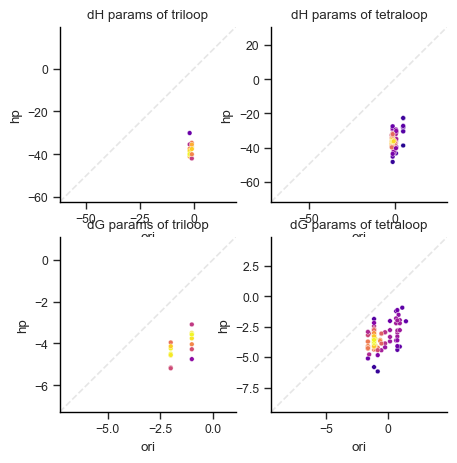

In [18]:
# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_hp_dict = fileio.read_json(param_set_hp_file)

fig, ax = plt.subplots(2,2,figsize=(5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_hp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

### Optimize the offset

In [ ]:
from scipy.optimize import minimize

def run_ddX_optimization(loop, val_df_dict, n_sample=50, n_run=5):
    def get_res_df(loss_arr, x_arr):
        res_df = pd.DataFrame(
            dict(loss=loss_arr,
             ddH=x_arr[:,0],
             ddG=x_arr[:,1]))#.sort_values(by='loss')
        return res_df

    x0 = np.array([0,0])
    loss_arr, x_arr = np.zeros(n_run), np.zeros((n_run, 2))
    for i in range(n_run):
        sampled_val_df = val_df_dict[loop].sample(n_sample)
        fun = lambda x: mupack.obj_fun_Tm_err(x, sampled_val_df=sampled_val_df, loop=loop)
        res = minimize(fun, x0, method='BFGS', tol=1e-1, options=dict(maxiter=20))
        loss_arr[i] = res.fun
        x_arr[i,:] = res.x

    res_df = get_res_df(loss_arr, x_arr)
    return res_df

In [ ]:
# Define val_df
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]

val_df_dict = dict()
val_df_dict['tetraloop'] = val_df.loc[[x.startswith('TET') for x in val_df.index]]
val_df_dict['triloop'] = val_df.loc[[x.startswith('TRI') for x in val_df.index]]

Do multiple runs of optimization on different subsampling data points, starting from 0 ddH & ddG, then take the average values and save to json.

In [ ]:
%%time
np.random.seed(42)
ddX = dict()
for loop in ['tetraloop', 'triloop']:
    res_df = run_ddX_optimization(loop, val_df_dict)
    ddX[loop] = dict(res_df.mean()[['ddH', 'ddG']])

print(ddX)
fileio.write_json(ddX, './models/ddX.json')

NameError: name 'run_ddX_optimization' is not defined

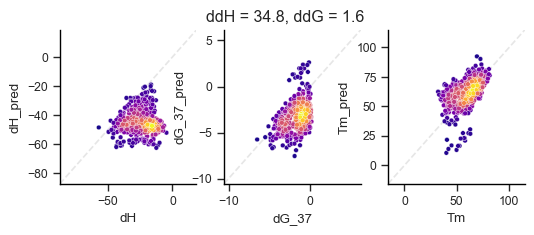

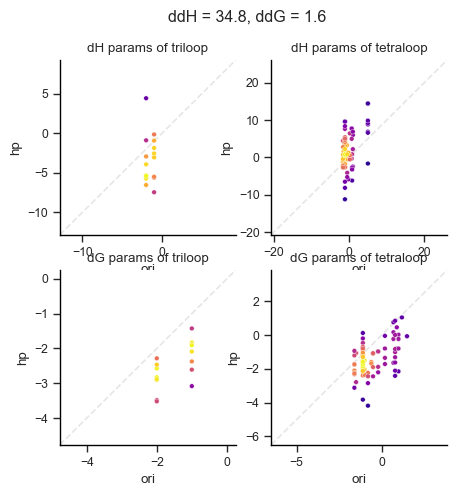

In [70]:
# Apply ddX and save to file

# Read in starting point json file
starting_p_file = './models/dna-nnn-tloop.json'
tmp_p_file = './models/dna-nnn-tloop-adj.json'
starting_p_dict = fileio.read_json(starting_p_file)

# Add new offset from `ddX`
for loop in ['tetraloop', 'triloop']:
    x_dict = ddX[loop]
    for i,p in enumerate(['dH', 'dG']):
        for k,v in starting_p_dict[p]['hairpin_'+loop].items():
            starting_p_dict[p]['hairpin_'+loop][k] = float(v + x_dict['d'+p])

# Save to temporary file
fileio.write_json(starting_p_dict, tmp_p_file)

val_df_4_test = val_df.loc[[(not x.startswith('VAR')) for x in val_df.index]].sample(500)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=tmp_p_file,
)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x[0], x[1]))
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_tmp_dict = fileio.read_json(tmp_p_file)
fig, ax = plt.subplots(2,2,figsize=(5,5))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x[0], x[1]))
for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_tmp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

### Extract hairpin_mismatch

In [73]:
# Get hairpin_mismatch params from `tmp_p_file`
tmp_p_dict = fileio.read_json(tmp_p_file)
tetloop_df = pd.DataFrame(dict(dH=tmp_p_dict['dH']['hairpin_tetraloop'], dG=tmp_p_dict['dG']['hairpin_tetraloop'])).reset_index(names=['hairpin_tetraloop'])
tetloop_df['hairpin_mismatch'] = tetloop_df['hairpin_tetraloop'].apply(lambda x: f'{x[-2]}{x[-1]}{x[0]}{x[1]}')
hpmm_df = tetloop_df.groupby('hairpin_mismatch')[['dH', 'dG']].apply(np.mean)

# Read in hairpin loop adjusted json file
hp_p_file = './models/dna-nnn-hploop.json'

# Add new offset from `ddX`
for i,p in enumerate(['dH', 'dG']):
    tmp_p_dict[p]['hairpin_mismatch'] = dict(hpmm_df[p])

# Save to hairpin param file
fileio.write_json(tmp_p_dict, hp_p_file)

## Internal loop parameters

### interior_1_1

#### Aggregate values from data

In [30]:
# Find mismatch constructs with the same secondary structure and scaffold
mm_df = arr_1M.query('Series == "MisMatches" & TargetStruct == "(((.(((....))).)))"')
mm_df = mm_df[mm_df.RefSeq.apply(lambda x: x[0] == 'G' and x[6] == 'C')]

# Get single mismatch parameter name (hard-coded)
# interior_1_1 is the alphabetically smaller, unique representation
flip_interior_1_1 = lambda x: f'{x[3:6]}{x[:3]}'
mm_df['interior_1_1_orient1'] = mm_df.RefSeq.apply(lambda x: f'{x[2:5]}{x[13:16]}')
mm_df['interior_1_1_orient2'] = mm_df.interior_1_1_orient1.apply(flip_interior_1_1)
mm_df['interior_1_1'] = mm_df.apply(lambda row: sorted([row.interior_1_1_orient1, row.interior_1_1_orient2])[0], axis=1)

# Aggregate dH dG values into interior_df
interior_df = mm_df.groupby('interior_1_1')[['dH', 'dG_37']].apply(np.mean)

# Check if we have data for all single mismatches
n_sym = 4**2
n_mm = 4**2 * 12
n_unique_interior_1_1 = int((n_mm - n_sym)/2 + n_sym)
assert n_unique_interior_1_1 == len(interior_df)

# Extend values to symmetric interior_1_1s (all_interior_df)
interior_df['flip'] = interior_df.reset_index().interior_1_1.apply(flip_interior_1_1).values

# Enumerate all interior_1_1
a = product('ATCG', repeat=4)
mm = lambda x: f'{"".join(x[:3])}{util.rcompliment(x[2])}{x[3]}{util.rcompliment(x[0])}'
all_interior_1_1 = [mm(i) for i in a]
all_interior_df = pd.DataFrame(columns=[], index=all_interior_1_1)

# Apply from unique value to all interior loops
all_interior_df = all_interior_df.join(interior_df[['dH', 'dG_37']])
all_interior_df.update(interior_df.set_index('flip'))
# Drop the WC ones (nan here)
all_interior_df = all_interior_df.dropna()

# Change column name from dG_37 to dG
all_interior_df.columns = ['dH', 'dG']

#### json file names

In [80]:
param_set_hp_file = './models/dna-nnn-tloop-adj.json' # start from last step
param_set_smm_raw_file = './models/dna-nnn-smm-raw.json' # raw interior_1_1 values filled in
param_set_smm_adj_file = './models/dna-nnn-smm-adj.json' # shifted and mm params extracted

#### Write interior_1_1 values to json

Note that `interior_1_1` not only includes single mismatches, but also WC, GT paring, etc. We will reapply this updated model to array data and only shift the single mismatch parameters. 

In [32]:
p_hp_dict = fileio.read_json(param_set_hp_file)
p_smm_dict = p_hp_dict.copy()

for p in ['dH', 'dG']:
    for k,v in dict(all_interior_df[p]).items():
        p_smm_dict[p]['interior_1_1'][k] = v
        
fileio.write_json(p_smm_dict, param_set_smm_raw_file)

#### Evaluate single mismatch param file on training set

In [33]:
%%time
# Use mm_df from last step as val_df
val_result_df = modeling.make_model_validation_df(
    mm_df.sample(100),
    model='nupack', 
    model_param_file=param_set_smm_raw_file,
)

CPU times: user 5.14 s, sys: 81.1 ms, total: 5.22 s
Wall time: 5.27 s


===== Save or load val_result_df below =====

In [83]:
# Save the full result (long run time)
val_result_df.to_csv('./data/models/out/train_result_dna-nnn-smm-raw.csv')

In [12]:
# Load the full result (long run time)
val_result_df = pd.read_csv('./data/models/out/train_result_dna-nnn-smm-raw.csv', index_col=0)

===================================

Median of offset on sampled training data: {'dH': -49.6311657153536, 'dG': -4.960606736498082}


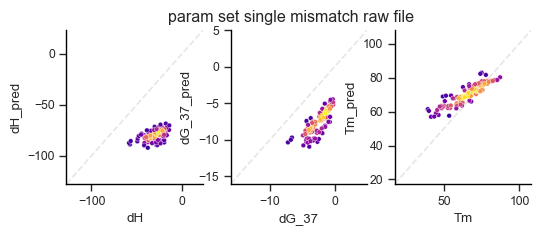

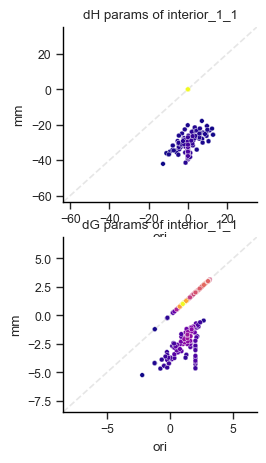

In [39]:
# Print the median of dH & dG offset
offset = dict()

offset['dH'] = np.median(val_result_df.dH_pred - val_result_df.dH)
offset['dG'] = np.median(val_result_df.dG_37_pred - val_result_df.dG_37)

print('Median of offset on sampled training data:',offset)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)
    
# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('param set single mismatch raw file')
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df.dropna(),
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
fig, ax = plt.subplots(2,1,figsize=(2.5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['interior_1_1']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p][loop], mm=p_smm_dict[p][loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='mm', ax=ax[i], show_cbar=False)
        ax[i].set_title('%s params of %s' % (p, loop))

#### Optimize smm offset

In [52]:
# Define val_df: single mismatches
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]

val_df_dict = dict()
val_df_dict['interior_1_1'] = val_df.loc[val_df.apply(lambda row: row.name.startswith('MM') and '((.(((' in row.TargetStruct, axis=1)]

Do multiple runs of optimization on different subsampling data points, starting from 0 ddH & ddG, then take the average values and save to json.

In [54]:
%%time
np.random.seed(42)
ddX = dict()
for loop in ['interior_1_1']:
    res_df = mupack.run_ddX_optimization(loop, val_df_dict,
                                         n_sample = 30, n_run=5,
                                         starting_p_file = param_set_smm_raw_file,
                                         tmp_p_file = './models/dna-nnn-smm-tmp.json')
    ddX[loop] = dict(res_df.mean()[['ddH', 'ddG']])

print(ddX)
fileio.write_json(ddX, './models/ddX_interior_1_1.json')

{'interior_1_1': {'ddH': 40.313950507201966, 'ddG': 5.5220362261370255}}
CPU times: user 6min 24s, sys: 4.24 s, total: 6min 28s
Wall time: 6min 30s


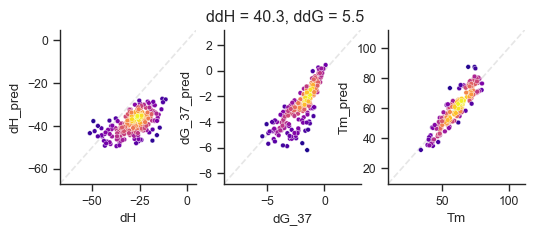

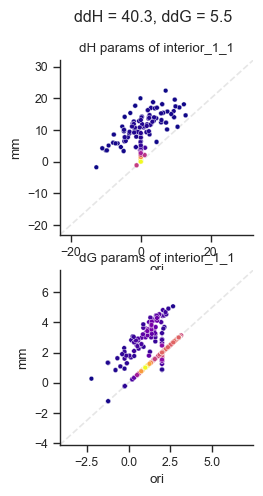

In [175]:
# === Apply ddX and save to file ===

# Add new offset from `ddX`
adj_interior_df = all_interior_df + np.array([ddX['interior_1_1']['ddH'], ddX['interior_1_1']['ddG']])

# Save adjusted values to json file
# Note that we cannot directly use the values from smm_raw file
# as this will shift the values for interior_1_1 we did not modify as well
p_hp_dict = fileio.read_json(param_set_hp_file)
p_smm_dict = p_hp_dict.copy()

for p in ['dH', 'dG']:
    for k,v in dict(adj_interior_df[p]).items():
        p_smm_dict[p]['interior_1_1'][k] = v
        
fileio.write_json(p_smm_dict, param_set_smm_adj_file)

# Evaluate again after shifting
val_df_4_test = val_df_dict['interior_1_1'].sample(200)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=param_set_smm_adj_file,
)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x_dict['ddH'], x_dict['ddG']))
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_hp_file)
p_smm_dict = fileio.read_json(param_set_smm_adj_file)

fig, ax = plt.subplots(2,1,figsize=(2.5,5))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x_dict['ddH'], x_dict['ddG']))
for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['interior_1_1']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p][loop], mm=p_smm_dict[p][loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='mm', ax=ax[i], show_cbar=False)
        ax[i].set_title('%s params of %s' % (p, loop))

### The rest of interior mismatch

#### Fit interior_mismatch as before

Shape of the feature matrix is (27732, 1360)

 dH
rank 48
shape of A_unknown (24979, 48)

 dG
rank 48
shape of A_unknown (24979, 48)
CPU times: user 22.2 s, sys: 13 s, total: 35.2 s
Wall time: 31.1 s


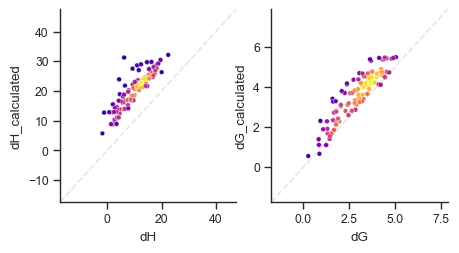

In [211]:
%%time
# Data: the standard dataset
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')

# Extract NUPACK features
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False, single_mm_stacks=False)
print("Shape of the feature matrix is", feats.shape)

# Get the fitted hairpinloop parameters from previous models and add the params to be fixed
fixed_pclass = ['hairpin_size', 'bulge_size', 'interior_size', 'hairpin_mismatch', 'hairpin_triloop', \
                'hairpin_tetraloop', 'terminal_mismatch', 'terminal_penalty', 'stack']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_smm_adj_file, fixed_pclass=fixed_pclass)

# Make sure there's no extra param here
assert len([x for x in feats.columns if x.startswith('interior_mismatch_stacks')]) == 0

lr_dict = defaultdict()
param_name_dict = dict(dH='dH', dG='dG_37')
for i,param in enumerate(param_name_dict):
    print('\n', param)
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, 
                                  param=param_name_dict[param], feats=feats, 
                                  train_only=True,
                                  fix_some_coef=True, 
                                  fix_coef_kwargs=dict(fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]]))

# Get the interior mismatch parameters we want
imm_df = pd.concat(
    [lr_dict[param].coef_df.loc[[x for x in lr_dict[param].coef_df.index if x.startswith('interior_mismatch')]]
     for param in param_name_dict],
    axis=1
)
imm_df.index = [x.split('#')[1] for x in imm_df.index]

# Calculate interior_1_1 from the new interior_mismatch parameters
# and compare to the directly aggregated interor_1_1 from the previous step
imm_size = p_ori_dict[p]['interior_size'][1] # index = n1 + n2 - 1
cmp_interior_df = adj_interior_df.rename_axis('interior_1_1').reset_index()
cmp_interior_df['mm1'] = cmp_interior_df.interior_1_1.apply(lambda x: f'{x[1:5]}')
cmp_interior_df['mm2'] = cmp_interior_df.interior_1_1.apply(lambda x: f'{x[4:6]}{x[:2]}')
smm_fun = lambda row: imm_df.loc[row.mm1, param_name_dict[param]] + imm_df.loc[row.mm2, param_name_dict[param]] + imm_size
for param in param_name_dict:
    cmp_interior_df[param+'_calculated'] = cmp_interior_df.apply(smm_fun, axis=1)

# Plot comparison before adjustment
fig, ax = plt.subplots(1, 2, figsize=(5,2.5))
for i, param in enumerate(param_name_dict):
    plotting.plot_colored_scatter_comparison(
        data=cmp_interior_df,
        x=param,
        y=param+'_calculated',
        show_cbar=False,
        ax=ax[i]
    )

ddX for internal mismatch parameters: {'dH': -5.088852066988929, 'dG': -0.29325384604186544}


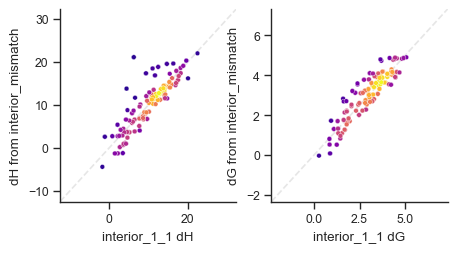

In [212]:
# Shift interior_mismatch to make consistent with interior_1_1
ddX = {k:0 for k in param_name_dict}
for param in param_name_dict:
    ddX[param] = np.median(cmp_interior_df[param] - cmp_interior_df[param+'_calculated']) / 2
print('ddX for internal mismatch parameters:', ddX)

imm_adj_df = imm_df + list(ddX.values())

# Make the same plot again, using shifting internal mismatch parameters
# so as to double check that things are consistent 

# Calculate interior_1_1 from the new interior_mismatch parameters
# and compare to the directly aggregated interor_1_1 from the previous step
imm_size = p_ori_dict[p]['interior_size'][1]
cmp_interior_df = adj_interior_df.rename_axis('interior_1_1').reset_index()
cmp_interior_df['mm1'] = cmp_interior_df.interior_1_1.apply(lambda x: f'{x[1:5]}')
cmp_interior_df['mm2'] = cmp_interior_df.interior_1_1.apply(lambda x: f'{x[4:6]}{x[:2]}')
smm_fun = lambda row: imm_adj_df.loc[row.mm1, param_name_dict[param]] + imm_adj_df.loc[row.mm2, param_name_dict[param]] + imm_size
for param in param_name_dict:
    cmp_interior_df[param+'_calculated'] = cmp_interior_df.apply(smm_fun, axis=1)

# Plot comparison before adjustment
fig, ax = plt.subplots(1, 2, figsize=(5,2.5))
for i, param in enumerate(param_name_dict):
    plotting.plot_colored_scatter_comparison(
        data=cmp_interior_df,
        x=param,
        y=param+'_calculated',
        show_cbar=False,
        ax=ax[i]
    )
    ax[i].set_xlabel(f'interior_1_1 {param}')
    ax[i].set_ylabel(f'{param} from interior_mismatch')

#### Fill out 1_2 and 2_2 values
from `imm_adj_df`

In [240]:
p_smm_dict = fileio.read_json(param_set_smm_adj_file)
p_smm_adj_dict = p_smm_dict.copy()

for p in param_name_dict:
    # Overwrite new interior mismatch values to dict
    for i,row in imm_adj_df.iterrows():
        p_smm_adj_dict[p]['interior_mismatch'][row.name] = row[param_name_dict[p]]
        
    # `interior_n1_n2` (mismatches)
    for n1, n2 in [(1,2), (2,2)]:
        interior_name = 'interior_%d_%d' % (n1, n2)
        for seq in p_smm_adj_dict[p][interior_name]:
            seq1, seq2 = seq[:n1+2], seq[n1+2:]
            mm1 = seq2[-2] + seq2[-1] + seq1[0] + seq1[1]
            mm2 = seq1[-2] + seq1[-1] + seq2[0] + seq2[1]
            new_value = p_smm_adj_dict[p]['interior_size'][n1+n2-1] + \
                p_smm_adj_dict[p]['interior_mismatch'][mm1] + \
                p_smm_adj_dict[p]['interior_mismatch'][mm2]

            p_smm_adj_dict[p][interior_name][seq] = new_value

In [241]:
fileio.write_json(p_smm_adj_dict, param_set_smm_adj_file)

Median of offset on sampled training data: {'dH': -23.405271497282172, 'dG': -3.475721635972519}
CPU times: user 8.82 s, sys: 2.81 s, total: 11.6 s
Wall time: 7.59 s


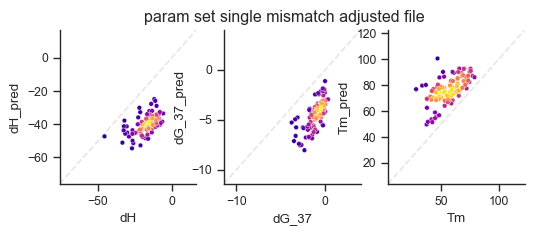

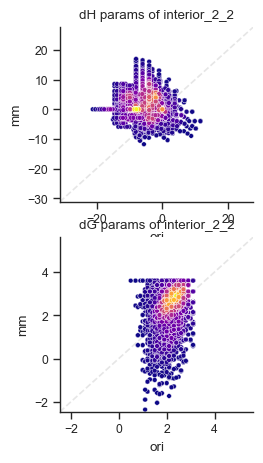

In [242]:
%%time
# Use double mismatches in the training set
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]
val_df = val_df.loc[val_df.TargetStruct.apply(lambda x: '((..((' in x and '))..))' in x)]
# val_df = val_df.loc[val_df.TargetStruct.apply(lambda x: '((.((' in x and ')).))' in x)]

val_result_df = modeling.make_model_validation_df(
    val_df.sample(100),
    model='nupack', 
    model_param_file=param_set_smm_adj_file,
)

# Print the median of dH & dG offset
offset = dict()

offset['dH'] = np.median(val_result_df.dH_pred - val_result_df.dH)
offset['dG'] = np.median(val_result_df.dG_37_pred - val_result_df.dG_37)

print('Median of offset on sampled training data:',offset)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)
    
# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('param set single mismatch adjusted file')
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df.dropna(),
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
fig, ax = plt.subplots(2,1,figsize=(2.5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['interior_2_2']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p][loop], mm=p_smm_adj_dict[p][loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='mm', ax=ax[i], show_cbar=False)
        ax[i].set_title('%s params of %s' % (p, loop))

In [243]:
%%time
np.random.seed(42)
val_df_dict['interior_2_2'] = val_df
ddX = dict()
for loop in ['interior_2_2']:
    res_df = mupack.run_ddX_optimization(loop, val_df_dict,
                                         n_sample = 30, n_run=5,
                                         starting_p_file = param_set_smm_adj_file,
                                         tmp_p_file = './models/dna-nnn-smm-tmp.json')
    ddX[loop] = dict(res_df.mean()[['ddH', 'ddG']])

print(ddX)
fileio.write_json(ddX, './models/ddX_interior_2_2.json')

{'interior_2_2': {'ddH': 6.382746002052654, 'ddG': 2.88067383956451}}
CPU times: user 5min 9s, sys: 3.22 s, total: 5min 12s
Wall time: 5min 13s


In [246]:
# Read in starting point json file
starting_p_file = param_set_smm_adj_file
adj_p_file = './models/dna-nnn-mm-adj.json'
starting_p_dict = fileio.read_json(starting_p_file)

# Add new offset from `ddX`
for loop in ['interior_2_2']:
    x_dict = ddX[loop]
    for i,p in enumerate(['dH', 'dG']):
        for k,v in starting_p_dict[p][loop].items():
            starting_p_dict[p][loop][k] = float(v + x_dict['d'+p])
            
fileio.write_json(starting_p_dict, adj_p_file)

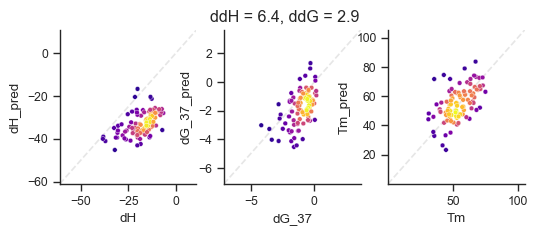

In [248]:
# === Apply ddX and save to file ===

# Evaluate again after shifting
inds = set(arr_1M.index) & set(mydata.data_split_dict['train_ind'])
val_df = arr_1M.loc[inds,:]
val_df = val_df.loc[val_df.TargetStruct.apply(lambda x: '((..((' in x and '))..))' in x)]
val_df_4_test = val_df.sample(100)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=adj_p_file,
)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))
plt.suptitle('ddH = %.1f, ddG = %.1f' % (x_dict['ddH'], x_dict['ddG']))
for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

Now the final product is `adj_p_file = './models/dna-nnn-mm-adj.json'`

## Evaluate

In [263]:
%%time
model_param_file = './models/dna-nnn-mm-adj.json'
inds = set(arr_1M.index) & set(mydata.data_split_dict['val_ind'])
val_df = arr_1M.loc[inds,:]

val_result_df = modeling.make_model_validation_df(
    val_df,
    model='nupack', 
    model_param_file=model_param_file,
)

# Save the full result (long run time)
val_result_df.to_csv('./data/models/out/val_result_%s.csv' % model_param_file.split('/')[-1].split('.')[0])

CPU times: user 1min 15s, sys: 953 ms, total: 1min 16s
Wall time: 1min 17s


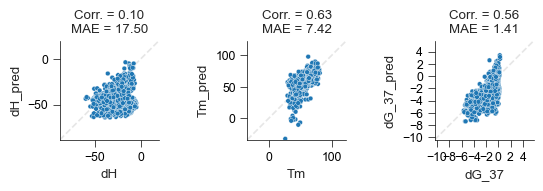

In [264]:
modeling.plot_validation_result_all_params(val_result_df)

# Shift one-step regression model

## Estimate weights for the objective function

<Axes: xlabel='dH_se', ylabel='Count'>

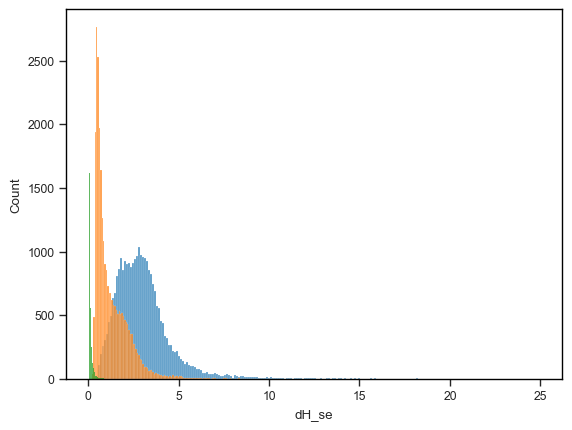

In [9]:
sns.histplot(mydata.arr.dH_se)
sns.histplot(mydata.arr.Tm_se)
sns.histplot(mydata.arr.dG_37_se)

In [13]:
get_weight = lambda x: 1/np.sqrt(np.median(x))
print('w(dH)=%.1f, w(dG)=%.1f, w(Tm)=%.1f' % (get_weight(mydata.arr.dH_se), get_weight(mydata.arr.dG_37_se), get_weight(mydata.arr.Tm_se)))

w(dH)=0.6, w(dG)=3.2, w(Tm)=1.0


#### Optimize offset

In [17]:
arr_1M = mydata.arr_1M
val_data_dict = mydata.prepare_val_df('val')

In [46]:
# Define val_df
inds = set(arr_1M.index) & set(mydata.data_split_dict['val_ind'])
val_df = arr_1M.loc[inds,:]

# The keys in the dictionary correspond to keys in the nupack file
val_df_dict = dict()
# val_df_dict['interior_1_1'] = val_df.loc[val_df.apply(lambda row: row.name.startswith('MM') and '((.(((' in row.TargetStruct, axis=1)]
val_df_dict['hairpin_tetraloop'] = val_df.loc[[x.startswith('TET') for x in val_df.index]]
val_df_dict['hairpin_triloop'] = val_df.loc[[x.startswith('TRI') for x in val_df.index]]
val_df_dict['interior_1_1'] = val_data_dict['ov'][val_data_dict['ov'].TargetStruct.apply(lambda x: '(((.(((' in x)]
val_df_dict['interior_2_2'] = val_data_dict['ov'][val_data_dict['ov'].TargetStruct.apply(lambda x: '(((..(((' in x)]

Do multiple runs of optimization on different subsampling data points, starting from 0 ddH & ddG, then take the average values and save to json.

In [49]:
val_df_dict['interior_1_1']

,a,b,center,sodium,DNA_conc,RefSeq,TargetStruct,Tm
SEQID,,,,,,,,
OV614,CGACGTGCTGTATGTGCTG,CAGCACATAAAGCACGTCG,TGT/AAA,0.0675,0.000001,"[CGACGTGCTGTATGTGCTG, CAGCACATAAAGCACGTCG]",(((((((((.(((((((((+))))))))).))))))))),55.5
OV136,CGACGTGCTGCATGTGCTG,CAGCACATGCTGCACGTCG,TGC/TCG,0.0675,0.000001,"[CGACGTGCTGCATGTGCTG, CAGCACATGCTGCACGTCG]",((((((((.((((((((((+)))))))))).)))))))),61.2
OV628,CGACGTGCTATATGTGCTG,CAGCACATTTAGCACGTCG,TAT/ATT,0.0675,0.000001,"[CGACGTGCTATATGTGCTG, CAGCACATTTAGCACGTCG]",((((((((((.((((((((+)))))))).)))))))))),55.3
OV334,CGACGTGCTGAATGTGCTG,CAGCACATCCAGCACGTCG,TGA/ACC,0.0675,0.000001,"[CGACGTGCTGAATGTGCTG, CAGCACATCCAGCACGTCG]",((((((((((.((((((((+)))))))).)))))))))),57.6
OV338,CGACGTGCCACATGTGCTG,CAGCACATTTGGCACGTCG,CAC/GTT,0.0675,0.000001,"[CGACGTGCCACATGTGCTG, CAGCACATTTGGCACGTCG]",((((((((((.((((((((+)))))))).)))))))))),57.6
...,...,...,...,...,...,...,...,...
OV189,CGACGTGCCTGATGTGCTG,CAGCACATCTGGCACGTCG,CTG/GTC,0.0675,0.000001,"[CGACGTGCCTGATGTGCTG, CAGCACATCTGGCACGTCG]",(((((((((.(((((((((+))))))))).))))))))),61.1
OV21,CGACGTGCGTCATGTGCTG,CAGCACATGGCGCACGTCG,GTC/CGG,0.0675,0.000001,"[CGACGTGCGTCATGTGCTG, CAGCACATGGCGCACGTCG]",(((((((((.(((((((((+))))))))).))))))))),63.5
OV130,CGACGTGCGAGATGTGCTG,CAGCACATCACGCACGTCG,GAG/CAC,0.0675,0.000001,"[CGACGTGCGAGATGTGCTG, CAGCACATCACGCACGTCG]",(((((((((.(((((((((+))))))))).))))))))),61.4


In [65]:
%%time
"""
Shift interior parameters on ov data
"""
param_set_file = './models/swift-lake-118.json'

np.random.seed(42)
ddX = dict()
for loop in ['interior_1_1', 'interior_2_2']:
    print('\n',loop)
    res_df = mupack.run_ddX_optimization(loop, val_df_dict,
                                         n_sample = 15, n_run=1, dna_type='duplex',
                                         starting_p_file = param_set_file,
                                         tmp_p_file = './models/dna-nnn-tmp.json')
    ddX[loop] = dict(res_df.mean()[['ddH', 'ddG']])

print(ddX)
fileio.write_json(ddX, './models/ddX_swift-lake-118.json')


 interior_1_1
-5.571274006836724
-5.571274006836724
-5.571274006836724

 interior_2_2
-6.373220685288871
-6.373220685288871
-6.373220685288871
{'interior_1_1': {'ddH': 0.0, 'ddG': 0.0}, 'interior_2_2': {'ddH': 0.0, 'ddG': 0.0}}
CPU times: user 21.8 s, sys: 237 ms, total: 22.1 s
Wall time: 22.2 s


In [69]:
np.nanmedian(mydata.arr.Tm_NUPACK_salt_corrected - mydata.arr.Tm)

12.517034219128526

In [71]:
val_result_df = pd.read_csv('./models/dna04_val_result_df.csv', index_col=[0,1])

In [72]:
tmp = val_result_df.loc['ov']
np.median(tmp.Tm_pred - tmp.Tm)

5.400121108765042

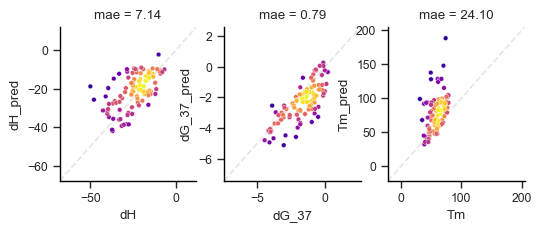

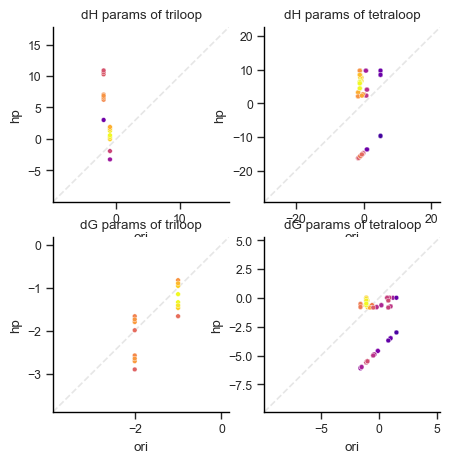

In [35]:
# Apply ddX and save to file

# Read in starting point json file
starting_p_file = './models/swift-lake-118.json'
tmp_p_file = './models/dna-nnn-swift-lake-118-adj.json'
starting_p_dict = fileio.read_json(starting_p_file)

# Add new offset from `ddX`
for loop in ['hairpin_tetraloop', 'hairpin_triloop']:
    x_dict = ddX[loop]
    for i,p in enumerate(['dH', 'dG']):
        for k,v in starting_p_dict[p][loop].items():
            starting_p_dict[p][loop][k] = float(v + x_dict['d'+p])

# Save to temporary file
fileio.write_json(starting_p_dict, tmp_p_file)

val_df_4_test = val_df.loc[[(not x.startswith('VAR')) for x in val_df.index]].sample(100)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=tmp_p_file,
)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))

for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    ax[i].set_title('mae = %.2f' % util.mae(val_result_df[p], val_result_df[p+'_pred']))
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_tmp_dict = fileio.read_json(tmp_p_file)
fig, ax = plt.subplots(2,2,figsize=(5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_tmp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

In [34]:
%%time
param_set_file = './models/swift-lake-118.json'

np.random.seed(42)
ddX = dict()
for loop in ['hairpin_tetraloop', 'hairpin_triloop']:
    res_df = mupack.run_ddX_optimization(loop, val_df_dict,
                                         n_sample = 15, n_run=1,
                                         starting_p_file = param_set_file,
                                         tmp_p_file = './models/dna-nnn-tmp.json')
    ddX[loop] = dict(res_df.mean()[['ddH', 'ddG']])

print(ddX)
fileio.write_json(ddX, './models/ddX_swift-lake-118.json')

{'hairpin_tetraloop': {'ddH': -14.667184766114511, 'ddG': -4.492612799924531}, 'hairpin_triloop': {'ddH': -19.321693282606038, 'ddG': -4.543344350908702}}
CPU times: user 1min 12s, sys: 911 ms, total: 1min 13s
Wall time: 1min 14s


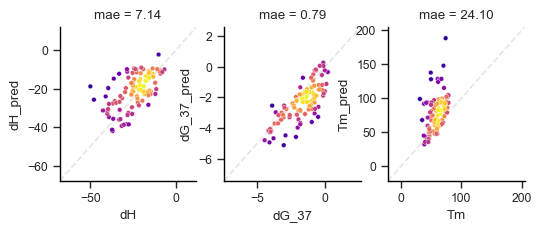

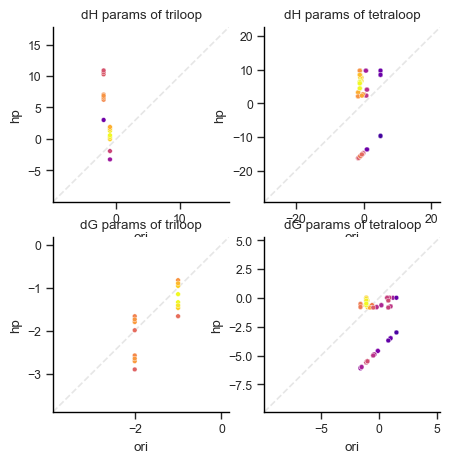

In [35]:
# Apply ddX and save to file

# Read in starting point json file
starting_p_file = './models/swift-lake-118.json'
tmp_p_file = './models/dna-nnn-swift-lake-118-adj.json'
starting_p_dict = fileio.read_json(starting_p_file)

# Add new offset from `ddX`
for loop in ['hairpin_tetraloop', 'hairpin_triloop']:
    x_dict = ddX[loop]
    for i,p in enumerate(['dH', 'dG']):
        for k,v in starting_p_dict[p][loop].items():
            starting_p_dict[p][loop][k] = float(v + x_dict['d'+p])

# Save to temporary file
fileio.write_json(starting_p_dict, tmp_p_file)

val_df_4_test = val_df.loc[[(not x.startswith('VAR')) for x in val_df.index]].sample(100)
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=tmp_p_file,
)

for c in ['dH_pred','Tm_pred','dG_37_pred']:
    val_result_df[c] = val_result_df[c].astype(float)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))

for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    ax[i].set_title('mae = %.2f' % util.mae(val_result_df[p], val_result_df[p+'_pred']))
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Plot parameters
p_ori_dict = fileio.read_json(param_set_template_file)
p_tmp_dict = fileio.read_json(tmp_p_file)
fig, ax = plt.subplots(2,2,figsize=(5,5))

for i,p in enumerate(['dH','dG']):
    for j,loop in enumerate(['triloop', 'tetraloop']):
        compare_df = pd.DataFrame(dict(ori=p_ori_dict[p]['hairpin_'+loop], hp=p_tmp_dict[p]['hairpin_'+loop]))
        plotting.plot_colored_scatter_comparison(data=compare_df.dropna(), x='ori', y='hp', ax=ax[i,j], show_cbar=False)
        ax[i,j].set_title('%s params of %s' % (p, loop))

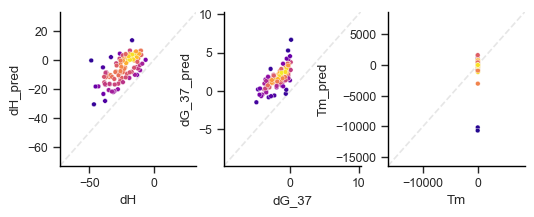

In [17]:
val_result_df = modeling.make_model_validation_df(
    val_df_4_test,
    model='nupack', 
    model_param_file=starting_p_file,
)

# Plot val_result_df 
fig, ax = plt.subplots(1,3,figsize=(6,2))

for i,p in enumerate(['dH', 'dG_37', 'Tm']):
    plotting.plot_colored_scatter_comparison(
        data=val_result_df,
        x=p,
        y=p+'_pred',
        ax=ax[i],
        show_cbar=False
    )

# Data prep

## Basic filtering

This removes non-hairpin forming control constructs to make model training easier.

### arr_v0

No 2 state filter. Not really used but kept to be consistent with historical analysis.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin
(30680, 42)


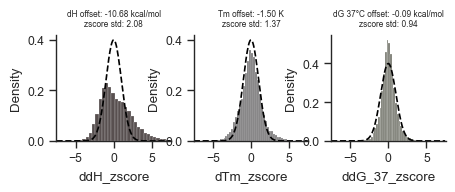

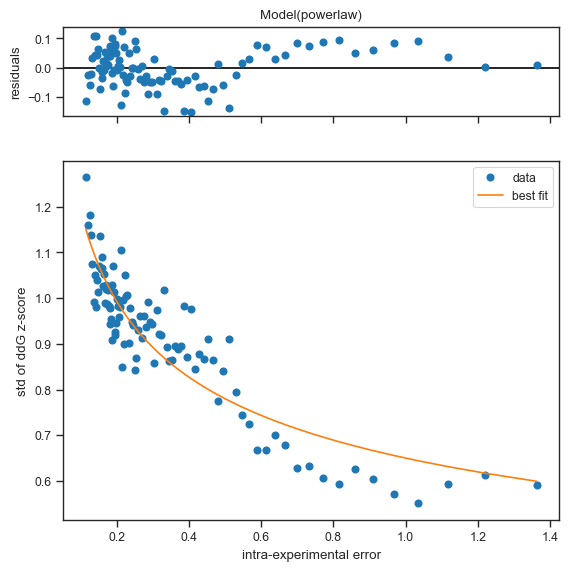

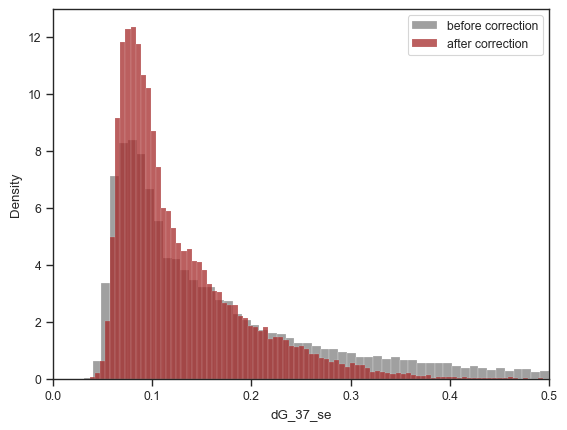

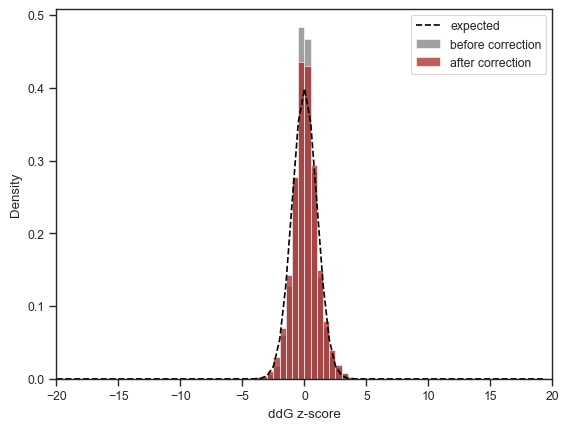

In [24]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))
arr = arraydata.data.join(arraydata.annotation)

excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])

print(arr.shape)
arr.to_csv(os.path.join('./data/models/raw', 'arr_v0_n=%d.csv' % arr.shape[0]))

### arr_v1

With (relaxed) 2-state filter & variant-level Tm filter.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
71.46% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5


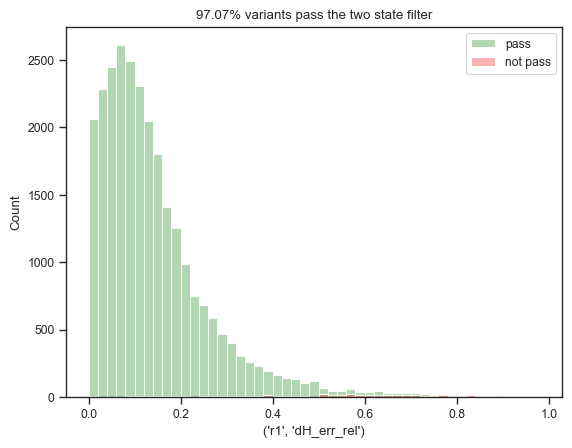

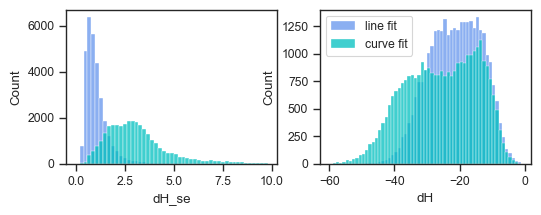

(27732, 45)


In [169]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file, sodium=0.083)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')

arraydata = ArrayData(replicate_df=replicate_df.iloc[:4,:],
                    annotation_file=annotation_file)

myfilter = "dH_err_rel < 0.5 & Tm_err_abs < 10 & redchi < 2 & n_inlier > 8"
pass_df = arraydata.filter_two_state(min_rep_pass=1, force_recalculate=True, overwrite_dH=False, 
                                     inplace=True, myfilter=myfilter)

variant_filter = 'Tm < 60 & Tm > 0'
arr = arraydata.data.join(arraydata.annotation).query(variant_filter)

excluded_construct_type = ['pseudoknot_pt_muts', 'PolyNTControls', 'RepeatControls', 'StemDangle_3p', 'StemDangle_53p', 'StemDangle_5p', 'PUMcontrols']
arr = arr[arr.reset_index().ConstructType.apply(lambda s: s not in excluded_construct_type).values]
arr = arr.dropna(subset=['ConstructType', 'RefSeq','TargetStruct'])

print(arr.shape)
arr.to_csv(os.path.join('./data/models/raw', 'arr_v1_n=%d.csv' % arr.shape[0]))

### arr_p_unfold

For sequence-to-melt-curve deep learning models. Control variants excluded in the arr file for structure energy models are included here.

86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
64.31% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211022_v6.CPvariant.gz
86.43% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5
Load from file ./data/fitted_variant/NNNlib2b_DNA_20211216_v9.CPvariant.gz
78.88% variants passed the filter n_clusters > 5 & dG_37_se < 2 & Tm_se < 25 & dH_se < 25 & RMSE < 0.5

Combining dH

Combining Tm

Combining dG_37

Combining dS

Combining fmax

Combining fmin


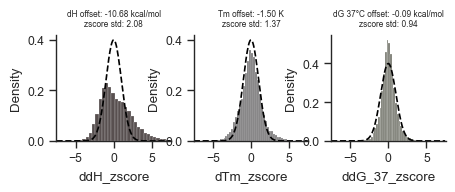

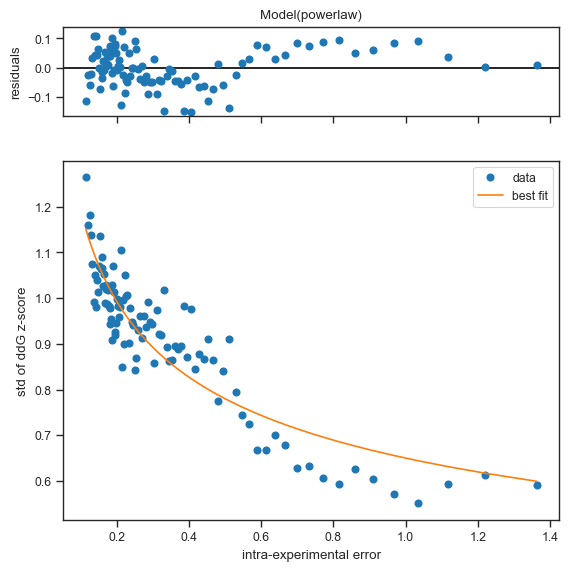

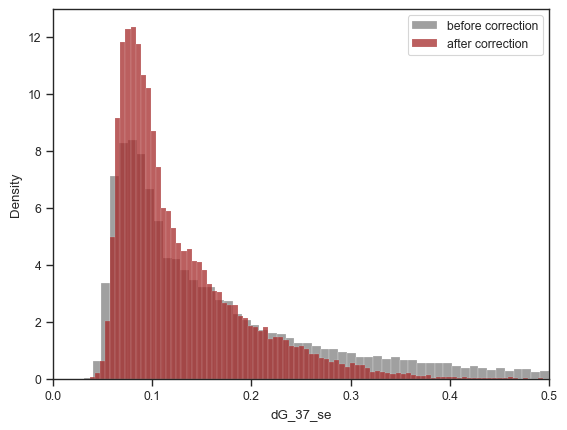

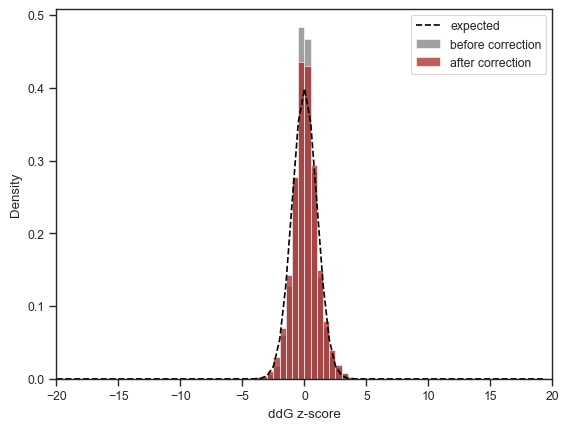

In [4]:
annotation_file = './data/annotation/NNNlib2b_annotation_20220519.tsv'
annotation = fileio.read_annotation(annotation_file)
replicate_df = pd.read_table('./data/nnnlib2b_replicates.tsv')
arraydata = ArrayData(replicate_df=replicate_df.iloc[:3,:],
                      annotation_file=annotation_file,
                      learn_error_adjust_from=('r1', 'r2'))

arraydata.p_unfold.to_csv('./data/models/raw/arr_p_unfold_n=%d.csv'%len(arraydata.p_unfold))

## Basic preprocessing

### Adjust offset

In [3]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)

(-4.0, 0.0)

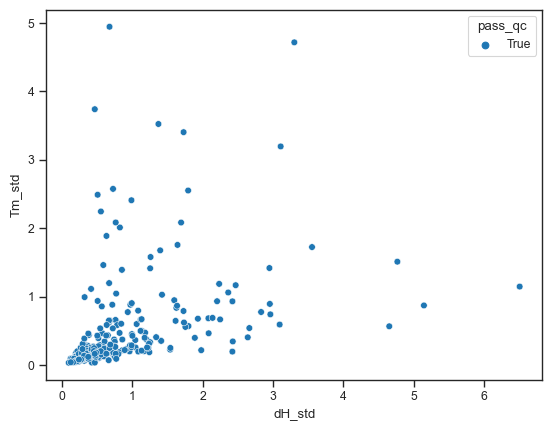

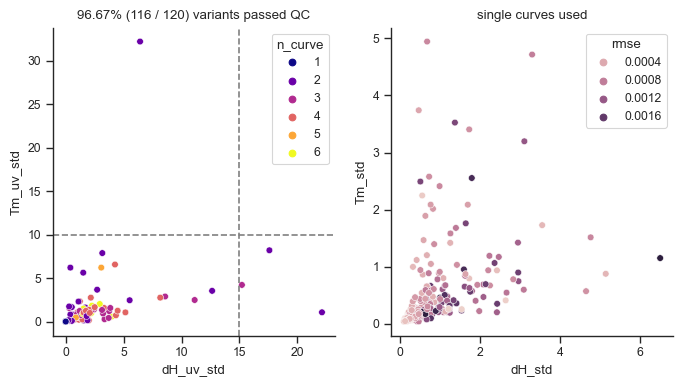

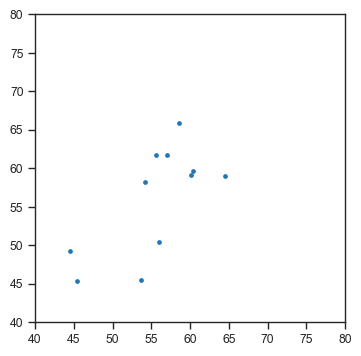

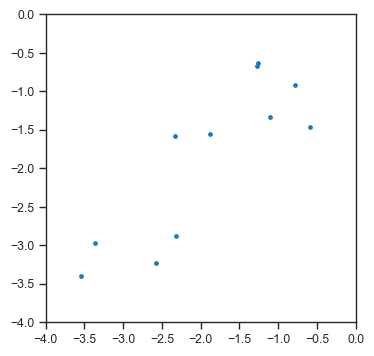

In [4]:
"""
Get the offset the violent way
"""
# copy pasted from command center for convenience
# only one peak found by AnalyzePeaks
hplc_clean_seqid = ["WC68_stem_3p", "WC68_stem_5p", "WC1025_split_5p", \
"WC1025_split_3p", "WC1375_stem_5p", "WC1375_stem_3p", "DMM004_5p", \
"DMM004_3p", "DMM005_5p", "DMM005_3p", "DMM006_5p", "DMM007_5p", \
"DMM007_3p", "BC0", "BC1", "BC6", "BC7", "BC8", "BC9", "BC10", \
"BC11", "MMCNNN2328", "MMCNNN2331", "MMCNNN2334", "MMCNNN2335", \
"MMCNNN2336", "MMCNNN2337", "MMTM1325", "MMTM176", "MMTM178", \
"MMTM179", "MMTM181", "MMTM185", "MMTM189", "MMTM1917", "MMTM29", \
"MMTM397", "MMTM509", "MMTM877", "DMM003_3p_rc", "DMM004_3p_rc", \
"DMM005_3p_rc", "DMM006_3p_rc", "DMM007_3p_rc", "TETNN1003", \
"TETNN999", "TETNN963", "TETNN979", "TETNNN1696", "TETNNN2082", \
"TETNNN1570", "HP002", "HP003", "HP004", "HP005", "HP007", "HP008", \
"HP010", "HP011", "HP012", "HP014", "HP015", "HP016", "HP017", \
"HP018", "HP019", "HP021", "HP022", "HP023", "HP024"]

sample_sheet_file = './data/uv_melt/ECLTables/ECLSampleSheet230502.csv'
datadir="./data/uv_melt/ECLExportAuto"
result_file='./data/uv_melt/uvmelt_230502_2.csv'
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'

result_df = pd.read_csv(result_file, index_col=0)
result_agg_df = uv.agg_fit_result(uvmelt_result_file=result_file,
                               agg_result_file=agg_result_file,
                               single_curve_qc_criteria='rmse < 0.002 & dH_std < 10 & Tm_std < 5 & dH < 0 & dH > -100 & Tm > 0 & Tm < 120',
                               Tm_std_thresh=10, dH_std_thresh=15,
                               sample_sheet_file=sample_sheet_file, 
                               clean=True, only_use_cooling=True)

result_agg_df = result_agg_df[result_agg_df.SEQID.isin(hplc_clean_seqid)]

vf = result_agg_df.query('is_hairpin & Na_mM == 25').sort_values(by=['conc_uM', 'n_curve', 'curve_date']).drop_duplicates(keep='last').merge(arr, how='left', on='SEQID')

df_q = vf.dropna(subset=['Tm', 'dG_37'])#.query(plot_query)
df_q.dG_37_uv_std = 0

dTm = np.median(df_q.Tm_uv - df_q.Tm)
df_q['Tm_adj'] = df_q.Tm + dTm
df_q['dG_37_adj'] = util.get_dG(dH=df_q.dH, Tm=df_q.Tm_adj, celsius=37)

plt.figure(figsize=(4,4))
plt.plot(df_q.Tm_uv, df_q.Tm_adj, '.')
lim = [40,80]
plt.xlim(lim)
plt.ylim(lim)

plt.figure(figsize=(4,4))
plt.plot(df_q.dG_37_uv, df_q.dG_37_adj, '.')
lim = [-4,0]
plt.xlim(lim)
plt.ylim(lim)

In [5]:
def adjust_offset(dH, Tm, dTm):
    Tm_adj = Tm + dTm
    dG_37_adj = util.get_dG(dH=dH, Tm=Tm_adj, celsius=37)
    dS_adj = dH / (Tm_adj + 273.15)
    return dict(dH=dH, dS=dS_adj, Tm=Tm_adj, dG_37=dG_37_adj)

cols = ['dH_se', 'Tm_se', 'dG_37_se', 'dS_se', 'RefSeq', 'TargetStruct', 'Series']
arr_adj = pd.DataFrame(adjust_offset(arr.dH, arr.Tm, dTm))
arr_adj[cols] = arr[cols]

arr_adj.to_csv(os.path.join('./data/models/processed', 'arr_v1_adjusted_n=%d.csv' % arr_adj.shape[0]))

In [6]:
dTm

8.63686781734635

### Salt correct array data to fucking 1M Na+

`arr_adj` -> `arr_1M`

In [171]:
%%time
param_names = ['dH','dS','Tm', 'dG_37']
arr_1M = pd.DataFrame(index=arr_adj.index, columns=param_names)

for i, row in arr_adj.iterrows():
    param_name_dict = util.get_Na_adjusted_param(Na=1.0,dH=row.dH, Tm=row.Tm, seq=row.RefSeq)
    arr_1M.loc[i,:] = param_name_dict

arr_1M[cols] = arr[cols]

# remove dangles
# they should have been removed already but just in case
sd_mask = arr_1M.apply(lambda row: not row.name.startswith('SD'), axis=1)
arr_1M = arr_1M[sd_mask.values]

arr_1M.to_csv('./data/models/processed/arr_v1_1M_n=%d.csv'%arr_1M.shape[0])

CPU times: user 5.64 s, sys: 107 ms, total: 5.74 s
Wall time: 5.67 s


## Update data split

Remove the variants measured by UV melting from the training set.

In [35]:
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=1)
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
arr_p_unfold = pd.read_csv('./data/models/raw/arr_p_unfold_n=30924.csv', index_col=0)


In [37]:
from sklearn.model_selection import train_test_split

ind2split = list(set(arr_1M.index) - set(uv_df.index))
series2split = arr_1M.loc[ind2split, 'Series']

train_val_ind, test_ind = train_test_split(ind2split, test_size=.05,
                                       random_state=42, stratify=series2split)
train_ind, val_ind = train_test_split(arr_1M.loc[train_val_ind,:].index, test_size=.05,
                                      random_state=43, stratify=arr_1M.loc[train_val_ind,:].Series)
test_ind += list(set(uv_df.index) & set(arr_1M.index))
n_train, n_val, n_test = len(train_ind), len(val_ind), len(test_ind)
print('train','val ','test')
print(n_train, n_val, n_test)

split_dict = dict(train_ind=train_ind.tolist(),
                  val_ind=val_ind.tolist(),
                  test_ind=test_ind)
with open('./data/models/raw/data_split.json', 'w') as fh:
    json.dump(split_dict, fh, indent=4)

additional_ind = list(set(arr_p_unfold.index) - set(arr_1M.index))

additional_train_val_ind, additional_test_ind = train_test_split(additional_ind, test_size=.1,
                                       random_state=44)
additional_train_ind, additional_val_ind = train_test_split(arr_p_unfold.loc[additional_train_val_ind,:].index.tolist(), test_size=.1,
                                      random_state=45)

split_dict['train_ind'] += additional_train_ind
split_dict['val_ind'] += additional_val_ind
split_dict['test_ind'] += additional_test_ind

fileio.write_json(split_dict, './data/models/raw/data_split_p_unfold.json')

train val  test
24971 1315 1446


## Other data prep

In [1]:
sl_mm = pd.read_csv('./data/literature/SantaLucia_single_mismatch.csv', index_col=0)
sl_mm['isWC'] = sl_mm.dG_37.apply(lambda x: x == 'WC')
sl_wc = pd.read_csv('./data/literature/SantaLucia_full.tsv', sep='\t', index_col=0)

def add_wc(row):
    if row.dG_37 == 'WC':
        return float(sl_wc.loc[row.name, 'dG_37'])
    else:
        return float(row.dG_37)
    
sl_mm['dG_37'] = sl_mm.apply(add_wc, axis=1)
sl_mm.to_csv('./data/literature/SantaLucia_mm_wc.csv')

NameError: name 'pd' is not defined

# Linear regression models

In [2]:
arr_1M = pd.read_csv('./data/models/processed/arr_v1_1M_n=27732.csv', index_col=0)
data_split_dict = fileio.read_json('./data/models/raw/data_split.json')
santa_lucia = fileio.read_santalucia_df('./data/literature/SantaLucia.tsv')

In [3]:
len(data_split_dict['val_ind'])

1315

## Model for plotting NN params

### Train

(27732, 1338)
CPU times: user 3min 50s, sys: 2min 51s, total: 6min 41s
Wall time: 1min 48s


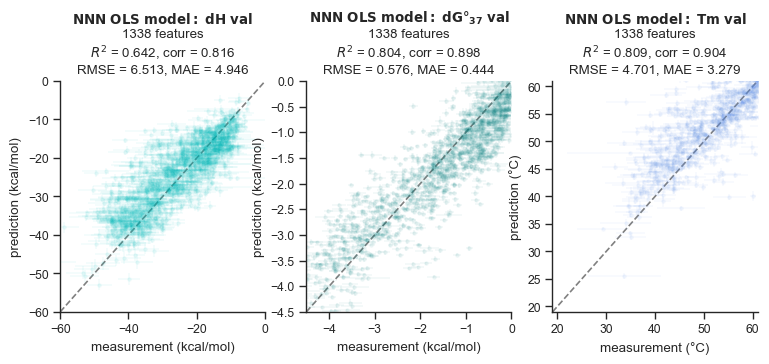

In [4]:
%%time
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=False, ignore_base_stack=False)
print(feats.shape)

lr_dict = dict(dH=None, dG=None)
fig, ax = plt.subplots(1, 3, figsize=(9,3))
lr_dict['dH'] = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dict['dG'] = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])
lr_dict['Tm'] = mf.fit_param(arr_1M, data_split_dict, param='Tm', feats=feats, ax=ax[2])

### Plot Nearest Neighbor parameters

From the OLS model, only plot the watson crick nearest neighbor parameters and compare to the SantaLucia parameters from the literature.

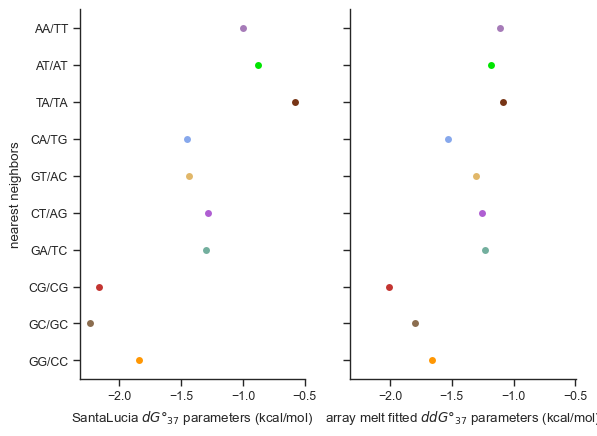

In [68]:
santa_lucia['feats'] = santa_lucia['motif'].apply(lambda x: x.replace('_','+') + '_((+))')
coef_df = lr_dict['dG'].coef_df.join(lr_dict['dH'].coef_df.rename(columns={'dG_37':'dH'}))
fit_vs_sl = santa_lucia.set_index('feats').join(
    coef_df, 
    lsuffix='_SantaLucia', rsuffix='_NNN')
fit_vs_sl['nearest neighbors'] = fit_vs_sl['motif'].apply(lambda x: x.replace('_','/'))
fit_vs_sl['dG_37_NNN'] +=  - np.mean(fit_vs_sl['dG_37_NNN']) + np.mean(fit_vs_sl['dG_37_SantaLucia'])
fit_vs_sl['dH_NNN'] +=  - np.mean(fit_vs_sl['dH_NNN']) + np.mean(fit_vs_sl['dH_SantaLucia'])

"""dG"""
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_SantaLucia', ax=ax[0], palette='cet_glasbey_dark')
ax[0].set_xlabel(r'SantaLucia $dG°_{37}$ parameters (kcal/mol)')
sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dG_37_NNN', ax=ax[1], palette='cet_glasbey_dark')
ax[1].set_xlabel(r'array melt fitted $ddG°_{37}$ parameters (kcal/mol)')
ax[1].set_ylabel('')
sns.despine()
util.save_fig('./fig/Fig4/NN_param_ArrayMelt_vs_SantaLucia_dG_37.pdf')


# fig, ax = plt.subplots(1, 2, sharey=True)
# sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dH_SantaLucia', ax=ax[0], palette='cet_glasbey_dark')
# ax[0].set_xlabel(r'SantaLucia $dH°$ parameters (kcal/mol)')
# sns.stripplot(data=fit_vs_sl, orient='h', y='nearest neighbors', x='dH_NNN', ax=ax[1], palette='cet_glasbey_dark')
# ax[1].set_xlabel(r'NNN $dH°$ parameters (kcal/mol)')
# ax[1].set_ylabel('')
# sns.despine()

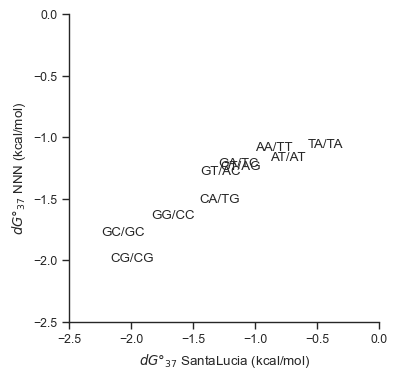

In [73]:
fig, ax = plt.subplots(figsize=(4,4))
for i in range(len(fit_vs_sl)):
    plt.text(fit_vs_sl.dG_37_SantaLucia[i], fit_vs_sl.dG_37_NNN[i], fit_vs_sl.motif[i].replace('_','/'))
    
plt.xlim([-2.5,0])
plt.ylim([-2.5,0])

plt.xlabel('$dG°_{37}$ SantaLucia (kcal/mol)')
plt.ylabel('$dG°_{37}$ NNN (kcal/mol)')
sns.despine()

util.save_fig('./fig/Fig4/NN_param_ArrayMelt_vs_SantaLucia_dG_scatter.pdf')

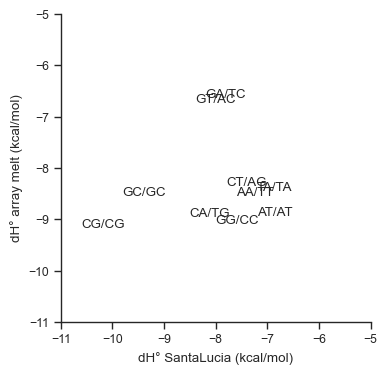

In [72]:
fig, ax = plt.subplots(figsize=(4,4))
for i in range(len(fit_vs_sl)):
    plt.text(fit_vs_sl.dH_SantaLucia[i], fit_vs_sl.dH_NNN[i], fit_vs_sl.motif[i].replace('_','/'))
    
plt.xlim([-11,-5])
plt.ylim([-11,-5])

plt.xlabel('dH° SantaLucia (kcal/mol)')
plt.ylabel('dH° array melt (kcal/mol)')
sns.despine()

util.save_fig('./fig/Fig4/NN_param_ArrayMelt_vs_SantaLucia_dH_scatter.pdf')

## Models for triloop & tetraloop sequence-specific parameters

In [10]:
param_set_template_file = './models/dna04.json'
fixed_pclass = ['hairpin_size', 'interior_size', 'terminal_penalty', 'stack']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_template_file, fixed_pclass=fixed_pclass)

(27732, 1399)
CPU times: user 2min 50s, sys: 2min 1s, total: 4min 52s
Wall time: 1min 29s


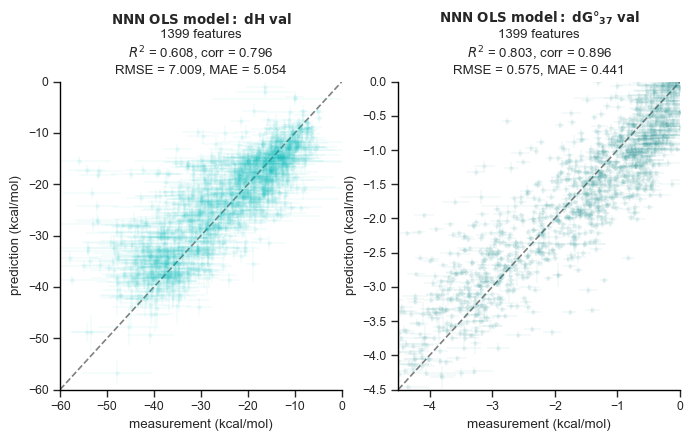

In [12]:
%%time 
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=True, ignore_base_stack=False)
print(feats.shape)

fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()

param_name_dict = dict(dH='dH', dG='dG_37')

for i,param in enumerate(param_name_dict):
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                     fix_some_coef=True, fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]])

(27732, 1399)
CPU times: user 2min 56s, sys: 2min 8s, total: 5min 5s
Wall time: 1min 24s


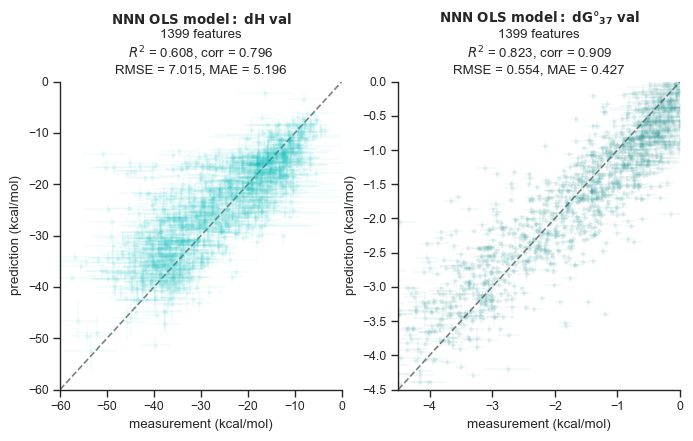

In [105]:
%%time
# with one single nupack-style hairpin mismatch parameter (.+.)
# no closing loop base pair param (as it's linearly dependent on the hairpin mismatch parameter)

feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_feature_list', 
                                    fit_intercept=False, symmetry=False, sep_base_stack=True, hairpin_mm=True, ignore_base_stack=False)
print(feats.shape)

lr_dict = dict(dH=None, dG=None)
fig, ax = plt.subplots(1, 2, figsize=(8,4))
lr_dict['dH'] = mf.fit_param(arr_1M, data_split_dict, param='dH', feats=feats, ax=ax[0])
lr_dict['dG'] = mf.fit_param(arr_1M, data_split_dict, param='dG_37', feats=feats, ax=ax[1])

### Save parameters to json

In [13]:
param_set_template_file = './models/dna04.json'
out_file = './models/dna-nnn-hairpin.json'
mupack.lr_dict_2_nupack_json(lr_dict, template_file=param_set_template_file, out_file=out_file, 
                             lr_step='hairpin', adjust_triloop_terminal_penalty=True,
                             extract_hairpin_mismatch=True)

### Validation

In [14]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv')
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')

In [15]:
hairpinloop_ind = [x for x in data_split_dict['val_ind'] if (x.startswith('TRI') or x.startswith('TET'))]

In [16]:
%%time
pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn-hairpin.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

CPU times: user 14 s, sys: 217 ms, total: 14.2 s
Wall time: 14.3 s


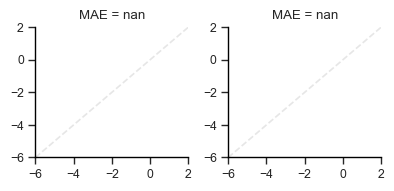

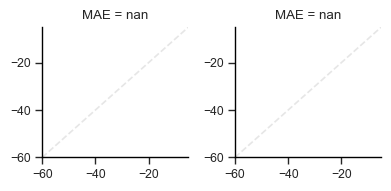

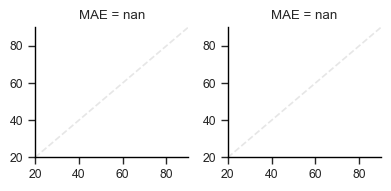

In [17]:
# Compare on array validation data
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dG_37', [-6, 2], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dH', [-60, -5], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'Tm', [20, 90], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_array_val_v1.pdf')

Triloop model works better than the tetraloop model.

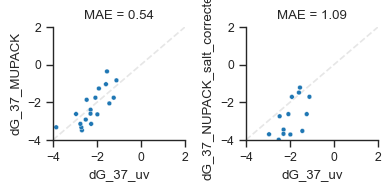

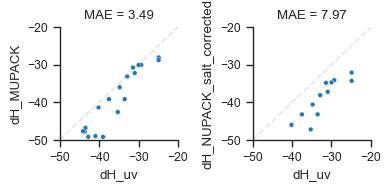

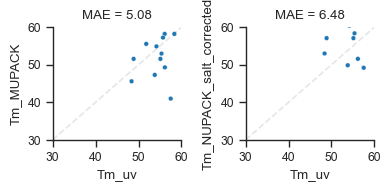

In [122]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = 'WC'
# hairpinloop_ind = [x for x in uv.index if ((x.startswith('TRI') or x.startswith('TET')) and x in arr.index)]
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)) and x in arr.index)]
""" END """

arr[cols] = np.nan
arr.loc[hairpinloop_ind, cols] = uv.loc[hairpinloop_ind, cols]

pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dG_37', [-4, 2], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dH', [-50, -20], color_by_density=False)
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'Tm', [30, 60], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

In [155]:
uv_df = pd.read_csv('./data/models/processed/uv_hairpin_arr_salt_hplc_filtered.csv', index_col=0)
uv_df.TargetStruct = uv_df.TargetStruct.fillna('('*6+'....'+')'*6)

In [160]:
modeling.get_model_prediction(df=uv_df, model='nupack', model_param_file='./models/dna-nnn-full.json', 
                              sodium=0.083, append_df_suffix='_new_NUPACK')

ConversionError: ["could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)", "could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)"]

## Full model with triloop & tetraloop seq params fixed

### Train

In [700]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False)
print(feats.shape)

(27732, 1360)
CPU times: user 13.2 s, sys: 144 ms, total: 13.4 s
Wall time: 13.6 s


Get the fitted hairpinloop parameters from previous models and add the params to be fixed from original dna04 file:

In [718]:
param_set_template_file = './models/dna-nnn-hairpin.json'
fixed_pclass = ['hairpin_size', 'interior_size', 'hairpin_mismatch', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_penalty', 'stack']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_template_file, fixed_pclass=fixed_pclass)

CPU times: user 9.71 s, sys: 17 s, total: 26.7 s
Wall time: 26.7 s


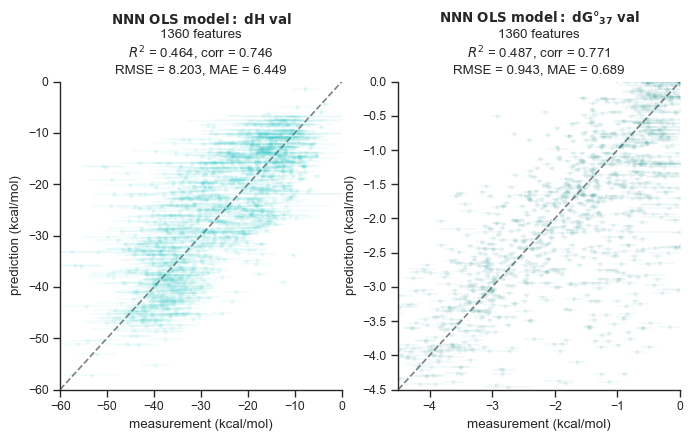

In [719]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()

for i,param in enumerate(param_name_dict):
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                     fix_some_coef=True, fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]])

### Save parameters to json

In [720]:
param_set_template_file = './models/dna-nnn-hairpin.json'
param_set_file = './models/dna-nnn-full.json'

mupack.lr_dict_2_nupack_json(lr_dict, param_set_template_file, param_set_file, lr_step='full', 
                             comment='Fix stack parameters')

### Validation

In [11]:
val_ind = data_split_dict['val_ind']

In [63]:
arr = arr_1M

In [64]:
hairpinloop_ind = [x for x in val_ind]# if (x.startswith('WC'))]# or x.startswith('TET'))]
hairpinloop_ind = np.random.choice(val_ind, 100, replace=False)
len(hairpinloop_ind)

100

In [65]:
%%time
pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn-full.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

CPU times: user 5.74 s, sys: 123 ms, total: 5.86 s
Wall time: 5.87 s


In [61]:
arr = arr.join(arr_adj[['Tm','dH','dG_37']], rsuffix='_adj')

In [66]:
arr.loc[hairpinloop_ind, 'Tm_adj']

SEQID
WC2933        65.293058
MMACP258      32.469124
WC1944        44.385732
MMACP3827     32.522143
TETNNN190     41.688909
                ...    
MMACP2343     37.860037
MMTM231       58.079331
BNNN2073      36.630696
BNNN970       32.346320
TETNNN1723    65.989337
Name: Tm_adj, Length: 100, dtype: float64

In [59]:
arr_adj = arr_adj.set_index('SEQID')

<Axes: xlabel='dG_37', ylabel='dG_37_MUPACK'>

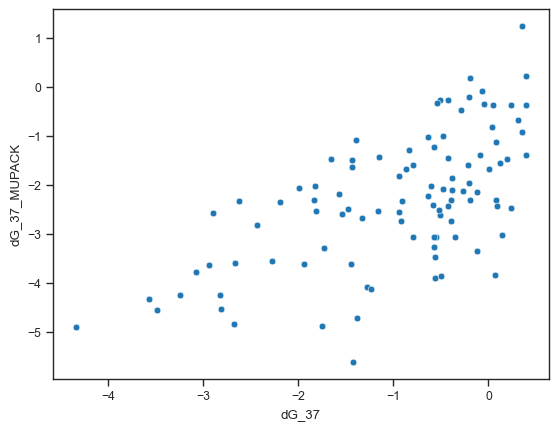

In [68]:
data = arr.loc[hairpinloop_ind]
param = 'dG_37'
x_suffix = '_adj'
sns.scatterplot(x=arr_adj.loc[hairpinloop_ind, param], y=data[param+'_MUPACK'])

In [72]:
for param in ['dH', 'Tm']:
    mae = util.mae(arr_adj.loc[hairpinloop_ind, param], data[param+'_MUPACK'])
    print(param, mae)

dH 6.90309638502303
Tm 26.343165473652526


ValueError: Could not interpret value `dG_37_NUPACK_salt_corrected` for parameter `y`

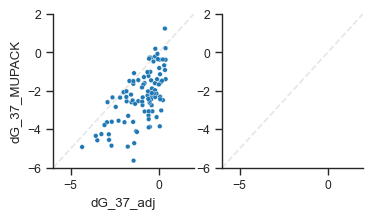

In [67]:
# Compare on array validation data
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dG_37', [-6,2])
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'dH', [-60, -5])
mupack.plot_mupack_nupack(arr.loc[hairpinloop_ind], '_adj', 'Tm', [20, 90])
# util.save_multi_image('./fig/models/MUPACK/full/model_pred_vs_array_val_v0.pdf')

In [566]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = ''
# hairpinloop_ind = [x for x in uv.index if ((x.startswith('TRI') or x.startswith('TET')) and x in arr.index)]
# hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)) and x in arr.index)]
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)))]
""" END """

arr[cols] = np.nan
arr.loc[hairpinloop_ind, cols] = uv.loc[hairpinloop_ind, cols]

pred = list(arr.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.RefSeq, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

arr[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
arr.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

cols = ['Tm_adj','dH_adj','dG_37_adj']
arr[cols] = arr_adj[['Tm','dH','dG_37']]

plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dG_37', [-5, 2], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'dH', [-50, -20], color_by_density=False)
plot_mupack_nupack(arr.loc[hairpinloop_ind], '_uv', 'Tm', [30, 70], color_by_density=False)
util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

KeyError: "['MMTM177'] not in index"

In [546]:
oligos = pd.read_csv('./data/uv_melt/ECLTables/ECLOligos230502.csv', index_col=0)

In [561]:
# compare on UV melting data
cols = ['dG_37_uv', 'Tm_uv', 'dH_uv']
uv = uv_df.query('Na_mM == 25 & is_hairpin')[cols].groupby('SEQID').apply(np.mean)

uv = uv.join(oligos[['sequence']])
uv['TargetStruct'] = '('*6 + '....' + ')'*6
""" Switch between triloop/ tetraloop/ combination of both here """
seqid_start = 'WC'
hairpinloop_ind = [x for x in uv.index if ((x.startswith(seqid_start)))]
""" END """

pred = list(uv.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.sequence, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna-nnn.json'), axis=1))

uv[['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = np.nan
uv.loc[hairpinloop_ind, ['dH_MUPACK', 'dS_MUPACK', 'Tm_MUPACK', 'dG_37_MUPACK']] = pred

pred = list(uv.loc[hairpinloop_ind,:].apply(lambda row: util.get_nupack_dH_dS_Tm_dG_37(row.sequence, row.TargetStruct, sodium=0.088, return_dict=False, param_set='./models/dna04.json'), axis=1))
cols = [x+'_NUPACK_salt_corrected' for x in ['dH', 'dS', 'Tm', 'dG_37']]
uv[cols] = np.nan
uv.loc[hairpinloop_ind, cols] = pred

plot_mupack_nupack(uv.loc[hairpinloop_ind], '_uv', 'dG_37', [-6, 2], color_by_density=False)
plot_mupack_nupack(uv.loc[hairpinloop_ind], '_uv', 'dH', [-60, -20], color_by_density=False)
plot_mupack_nupack(uv.loc[hairpinloop_ind], '_uv', 'Tm', [30, 70], color_by_density=False)
# util.save_multi_image('./fig/models/MUPACK/model_pred_vs_uv_%s_v1.pdf' % seqid_start)

ConversionError: ["could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)", "could not convert to rvalue reference (#0, <class 'float'> → boost::container::small_vector<nupack::Strand, 4ul, void, void>)"]

TODO:
- [ ] Wrap validation in a function
- [ ] Plot performance on HP UV melting dataset

## NUPACK model

### Train

In [10]:
%%time
feats = mf.get_feature_count_matrix(arr_1M, feature_method='get_nupack_feature_list', 
                                    feature_style='nupack', fit_intercept=False, directly_fit_3_4_hairpin_loop=False)
print(feats.shape)

(27732, 162)
CPU times: user 13.1 s, sys: 131 ms, total: 13.2 s
Wall time: 13.2 s


In [142]:
len([x for x in feats.columns if x.startswith('stack')])

16

In [16]:
np.unique([x.split('#')[0] for x in feats.columns])

array(['bulge_size', 'hairpin_loop_mid', 'hairpin_mismatch',
       'hairpin_size', 'interior_mismatch', 'interior_size', 'stack',
       'terminal_penalty'], dtype='<U17')

In [151]:
param_set_template_file = './models/dna04.json'
fixed_pclass = ['hairpin_size', 'interior_size', 'bulge_size', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_mismatch']
fixed_coef_df, fixed_feature_names = mupack.get_fixed_params(param_set_template_file=param_set_template_file, fixed_pclass=fixed_pclass)
print(len(fixed_feature_names))

316


In [152]:
fixed_feature_names = [x for x in fixed_feature_names if x in feats.columns]
print('#fixed features =', len(fixed_feature_names))

#fixed features = 10


In [153]:
fixed_coef_df.loc[fixed_feature_names]

,dH,dG
bulge_size#1,0.0,4.0
bulge_size#2,0.0,2.9
hairpin_size#3,0.0,3.5
hairpin_size#4,0.0,3.5
hairpin_size#11,0.0,4.4
hairpin_size#14,0.0,4.6
hairpin_size#17,0.0,4.9
hairpin_size#20,0.0,5.1
interior_size#2,0.0,5.0
interior_size#4,0.0,3.6


CPU times: user 13 s, sys: 20.1 s, total: 33.1 s
Wall time: 26.4 s


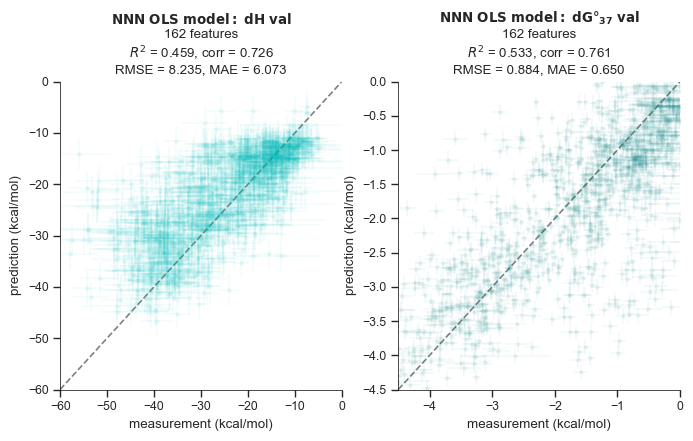

In [154]:
%%time 
fig, ax = plt.subplots(1, 2, figsize=(8,4))

lr_dict = defaultdict()
param_name_dict = dict(dH='dH', dG='dG_37')
for i,param in enumerate(param_name_dict):
    lr_dict[param] = mf.fit_param(arr_1M, data_split_dict, param=param_name_dict[param], feats=feats, ax=ax[i],
                     fix_some_coef=True, fixed_feature_names=fixed_feature_names, coef_df=fixed_coef_df[[param]])

### Save parameters to json

In [155]:
param_set_template_file = './models/dna04.json'
param_set_file = './models/dna-nnn-1step.json'

mupack.lr_dict_2_nupack_json(lr_dict, param_set_template_file, param_set_file, lr_step='full', 
                             comment='One step fitting')

### Validation

In [148]:
arr = pd.read_csv('./data/models/raw/arr_v1_n=27732.csv', index_col=0)
arr_adj = pd.read_csv('./data/models/processed/arr_v1_adjusted_n=27732.csv', index_col=0)
agg_result_file='./data/uv_melt/uvmelt_agg_230502.csv'
uv_df = pd.read_csv(agg_result_file, index_col=0).set_index('SEQID')

In [149]:
hairpinloop_ind = [x for x in data_split_dict['val_ind'] if (x.startswith('TRI')) and x in arr_adj.index]#[:50]

val_df = arr_adj.loc[hairpinloop_ind,:]
print(len(val_df))

55


CPU times: user 6.17 s, sys: 185 ms, total: 6.35 s
Wall time: 5.8 s


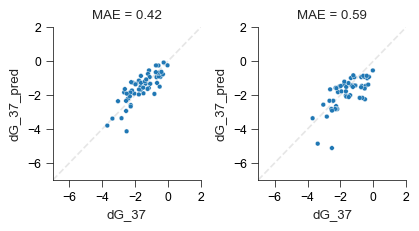

In [150]:
%%time
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

fig, ax = plt.subplots(1, 2, figsize=(4.25, 2.4))

val_result_df_nnn = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna-nnn-1step.json',)
modeling.plot_validation_result(val_result_df_nnn, param='dG_37', lim=[-7,2], ax=ax[0])

val_result_df_nupack = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna04.json',)
modeling.plot_validation_result(val_result_df_nupack, param='dG_37', lim=[-7,2], ax=ax[1])

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(2))
    a.yaxis.set_major_locator(MultipleLocator(2))
    a.tick_params(colors='k', width=.5)
    
# util.save_fig('./fig/Fig4/Validation/dna-nnn-hairpin_array_val_set_triloop_tetraloop.pdf')

CPU times: user 10.9 s, sys: 272 ms, total: 11.2 s
Wall time: 10.6 s


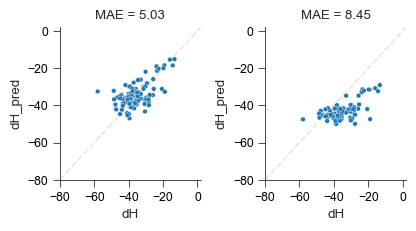

In [124]:
%%time
matplotlib.rc('axes',edgecolor='k', linewidth=.5)

fig, ax = plt.subplots(1, 2, figsize=(4.25, 2.4))

val_result_df = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna-nnn-1step.json',)
modeling.plot_validation_result(val_result_df, param='dH', lim=[-80,2], ax=ax[0])

val_result_df = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna04.json',)
modeling.plot_validation_result(val_result_df, param='dH', lim=[-80,2], ax=ax[1])

for a in ax:
    a.xaxis.set_major_locator(MultipleLocator(20))
    a.yaxis.set_major_locator(MultipleLocator(20))
    a.tick_params(colors='k', width=.5)
    
# util.save_fig('./fig/Fig4/Validation/dna-nnn-hairpin_array_val_set_triloop_tetraloop.pdf')

In [71]:
val_result_df = modeling.make_model_validation_df(val_df, 
                                  model='nupack', model_param_file='./models/dna-nnn-1step.json',)

In [157]:
pdict_ori = fileio.read_json('./models/dna04.json')
pdict = fileio.read_json('./models/dna-nnn-1step.json')
pdict_2step = fileio.read_json('./models/dna-nnn-full.json')

In [160]:
pdict['dG']['interior_1_1']

{'AAATAT': 1.8183123570930395,
 'AAATCT': 1.9644093469269617,
 'AAATGT': 1.4858611996291646,
 'AAATTT': 5.0,
 'ACATAT': 1.7399006968891442,
 'ACATCT': 2.512373626664368,
 'ACATGT': 5.0,
 'ACATTT': 1.7405295254109814,
 'AGATAT': 0.6459309491433212,
 'AGATCT': 5.0,
 'AGATGT': 0.852629186772258,
 'AGATTT': 0.9648968582373869,
 'ATATAT': 5.0,
 'ATATCT': 1.876759779699191,
 'ATATGT': 0.37569435568462817,
 'ATATTT': 1.4805059583182039,
 'AACGAT': 1.1610408121483728,
 'AACGCT': 1.0904568805467694,
 'AACGGT': -0.0204796110209573,
 'AACGTT': 5.0,
 'ACCGAT': 1.4128839745580897,
 'ACCGCT': 2.466343282502873,
 'ACCGGT': 5.0,
 'ACCGTT': 1.6218560593135234,
 'AGCGAT': -0.13889400950729236,
 'AGCGCT': 5.0,
 'AGCGGT': -0.38086048655324767,
 'AGCGTT': 0.3477087593106063,
 'ATCGAT': 5.0,
 'ATCGCT': 1.5215669294308367,
 'ATCGGT': -0.022386614910288483,
 'ATCGTT': 1.3160642658039314,
 'AAGCAT': 1.5579486980615045,
 'AAGCCT': 1.4267656520737724,
 'AAGCGT': 0.8315114050786332,
 'AAGCTT': 5.0,
 'ACGCAT': 1.0

<Axes: ylabel='Count'>

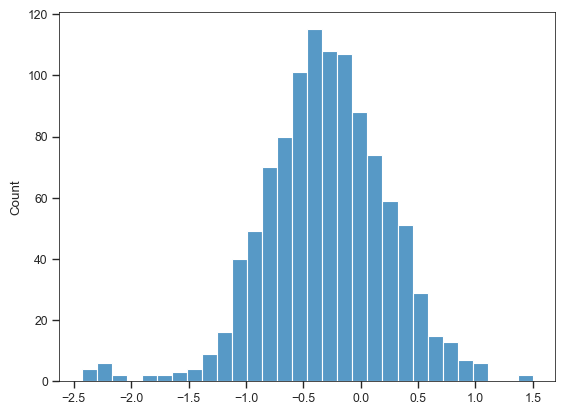

In [96]:
sns.histplot(list(pdict['dG']['hairpin_tetraloop'].values()))

<Axes: ylabel='Count'>

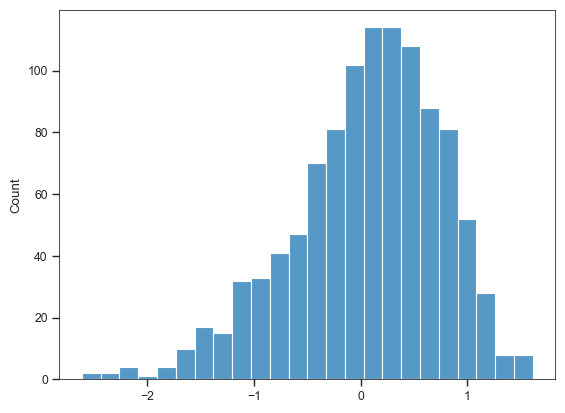

In [101]:
sns.histplot(list(pdict_2step['dG']['hairpin_tetraloop'].values()))

(-2.5, 2.5)

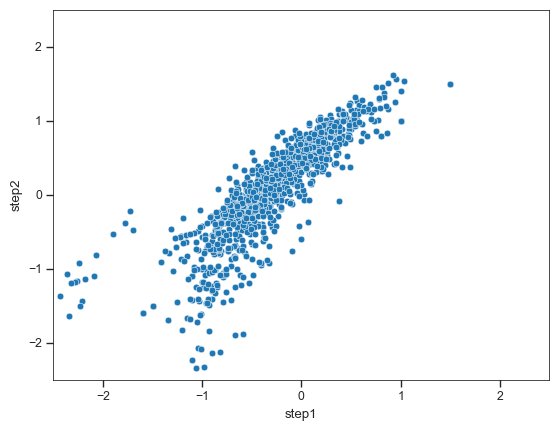

In [104]:
df = pd.DataFrame(data=dict(step1=pdict['dG']['hairpin_tetraloop'], step2=pdict_2step['dG']['hairpin_tetraloop']))
sns.scatterplot(data=df, x='step1', y='step2')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])

(-2.5, 2.5)

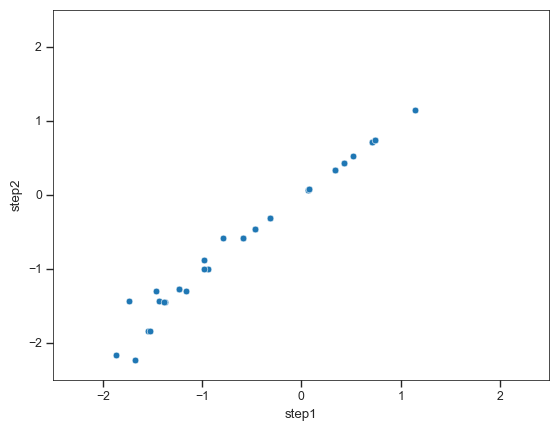

In [158]:
df = pd.DataFrame(data=dict(step1=pdict['dG']['stack'], step2=pdict_ori['dG']['stack']))
sns.scatterplot(data=df, x='step1', y='step2')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])

<Axes: ylabel='Count'>

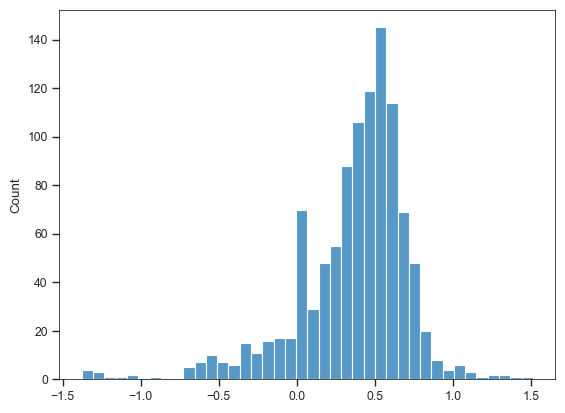

In [107]:
sns.histplot(df.step2 - df.step1)

In [109]:
df.loc[df.step2 - df.step1 < -1]

,step1,step2
ACGCGT,-1.044485,-2.068667
AGCGCT,-0.585158,-1.879287
AGGCCT,-0.666682,-1.892631
TGCGCA,-0.979240,-2.336445
TGGCCA,-1.060764,-2.349789
CCGCGG,-1.013290,-2.090022
CGCGCG,-1.225657,-2.602250
CGGCCG,-1.307182,-2.615594
GCGCGC,-1.100862,-2.230589
GGCGCC,-0.817235,-2.123595


<Axes: ylabel='Count'>

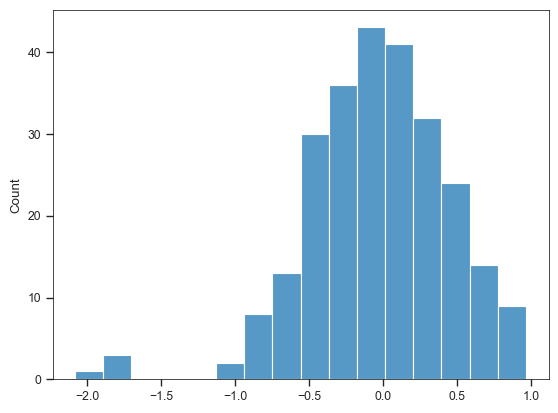

In [97]:
sns.histplot(list(pdict['dG']['hairpin_triloop'].values()))